# Bi-LSTM for Speech vs Noise Classification (MS-SNSD Dataset)

This notebook builds and trains a Bidirectional LSTM model using features extracted from the MS-SNSD dataset.

In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten, TimeDistributed, BatchNormalization
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Dropout
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

## Load Data

In [4]:
# Load the extracted features dataset
df = pd.read_csv("train_data.csv")
X = df.drop("label", axis=1).values
y = df["label"].values

## Preprocessing and Sequence Framing

In [5]:
# Normalize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Frame into sequences of 32 frames
sequence_length = 32
num_sequences = len(X_scaled) // sequence_length
X_seq = X_scaled[:num_sequences * sequence_length].reshape(num_sequences, sequence_length, -1)
y_seq = y[:num_sequences * sequence_length].reshape(num_sequences, sequence_length)
y_seq = (y_seq.mean(axis=1) > 0.5).astype(int)  # 1 if mostly speech

# One-hot encode labels
y_seq_cat = to_categorical(y_seq)

## Train/Test Split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X_seq, y_seq_cat, test_size=0.2, random_state=42, stratify=y_seq
)

## Build Bi-LSTM Model

In [7]:
model = Sequential()
model.add(Bidirectional(LSTM(128, return_sequences=False, dropout=0.3), input_shape=(sequence_length, X_seq.shape[2])))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(2, activation='softmax'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## Compile and Train

In [8]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.1)

Epoch 1/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 118ms/step - accuracy: 0.6958 - loss: 0.5629 - val_accuracy: 0.8776 - val_loss: 0.2989
Epoch 2/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - accuracy: 0.8548 - loss: 0.3412 - val_accuracy: 0.8776 - val_loss: 0.2979
Epoch 3/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - accuracy: 0.8851 - loss: 0.3010 - val_accuracy: 0.9056 - val_loss: 0.1997
Epoch 4/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 0.8872 - loss: 0.2656 - val_accuracy: 0.9126 - val_loss: 0.2172
Epoch 5/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - accuracy: 0.8971 - loss: 0.2550 - val_accuracy: 0.9266 - val_loss: 0.1638
Epoch 6/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - accuracy: 0.9111 - loss: 0.2224 - val_accuracy: 0.9510 - val_loss: 0.1355
Epoch 7/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 110ms/step - accuracy: 0.9162 - loss: 0.2080 - val_accuracy: 0.9510 - val_loss: 0.1749
Epoch 8/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - accuracy: 0.9132 - loss: 0.2158 - val_accuracy: 0.9371 

## Evaluate Model

In [9]:
loss, acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc:.2%}")

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9223 - loss: 0.2033
Test Accuracy: 92.72%


## Plot Training Performance

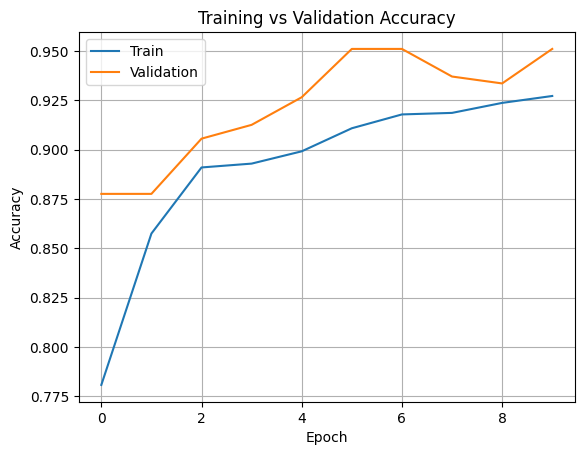

In [10]:
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.grid(True)
plt.legend()
plt.show()

In [16]:
# Define the CNN + LSTM model (model 2)
model2 = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(sequence_length, X_seq.shape[2])),
    MaxPooling1D(pool_size=2),
    LSTM(64, return_sequences=False),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(2, activation='softmax')
])

model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model2.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Evaluate
loss, accuracy = model2.evaluate(X_test, y_test)
print(f"\n✅ Model 2 Test Accuracy: {accuracy*100:.2f}%")

# Classification report
y_pred = (model2.predict(X_test) > 0.5).astype("int32")
y_pred_classes = np.argmax(y_pred, axis=1)  # convert from one-hot to class labels
y_true_classes = np.argmax(y_test, axis=1)  # same for y_test

print("\nClassification Report:\n", classification_report(y_true_classes, y_pred_classes))
print("\nConfusion Matrix:\n", confusion_matrix(y_true_classes, y_pred_classes))

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.7491 - loss: 0.5139 - val_accuracy: 0.8950 - val_loss: 0.2591
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9016 - loss: 0.2611 - val_accuracy: 0.9006 - val_loss: 0.2308
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9239 - loss: 0.1931 - val_accuracy: 0.9118 - val_loss: 0.2084
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.9372 - loss: 0.1838 - val_accuracy: 0.9272 - val_loss: 0.1825
Epoch 5/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9453 - loss: 0.1408 - val_accuracy: 0.9202 - val_loss: 0.1989
Epoch 6/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9558 - loss: 0.1194 - val_accuracy: 0.9160 - val_loss: 0.2082
Epoch 7/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9578 - loss: 0.1187 - val_accuracy: 0.9230 - val_loss: 0.2169
Epoch 8/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9493 - loss: 0.1272 - val_accuracy: 0.9146 - val_loss: 0.